In [ ]:
import warnings
import pandas as pd
!pip install datetools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split as split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import svm

  Created wheel for datetools: filename=DateTools-1.1-py3-none-any.whl size=6072 sha256=b8e5e077e8b937dba70ec8c5df7b217c696f3ee82e19b78e28ce0127e33fa39e
  Stored in directory: /root/.cache/pip/wheels/28/49/b0/199dd655d175f3a60ff31a77303e843139ad42e3db224a2f7c
Successfully built datetools


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
sns.set(style="whitegrid", color_codes=True)

In [ ]:
path_cleveland = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
path_hungary = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data"
path_swiss = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data"
path_veniceb = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data"

paths = [path_cleveland, path_hungary, path_swiss, path_veniceb]
names = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", 
         "ca", "thal", "target"]
df = pd.concat(map(lambda x: pd.read_csv(x, names=names), paths))

print(df.head())

    age  sex   cp trestbps   chol  fbs restecg thalach exang oldpeak slope  \
0  63.0  1.0  1.0    145.0  233.0  1.0     2.0   150.0   0.0     2.3   3.0   
1  67.0  1.0  4.0    160.0  286.0  0.0     2.0   108.0   1.0     1.5   2.0   
2  67.0  1.0  4.0    120.0  229.0  0.0     2.0   129.0   1.0     2.6   2.0   
3  37.0  1.0  3.0    130.0  250.0  0.0     0.0   187.0   0.0     3.5   3.0   
4  41.0  0.0  2.0    130.0  204.0  0.0     2.0   172.0   0.0     1.4   1.0   

    ca thal  target  
0  0.0  6.0       0  
1  3.0  3.0       2  
2  2.0  7.0       1  
3  0.0  3.0       0  
4  0.0  3.0       0  


In [ ]:
df.replace("?", np.nan, inplace=True)
print(df.isnull().sum())

age           0
sex           0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalach      55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
target        0
dtype: int64


In [ ]:
df.dropna(axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
df['ca'] = pd.to_numeric(df['ca'], errors='coerce')
df[['age', 'sex', 'fbs', 'exang', 'ca']] = df[['age', 'sex', 'fbs', 'exang', 'ca']].astype(int)
df[['trestbps', 'chol', 'thalach', 'oldpeak']] = df[['trestbps', 'chol', 'thalach', 'oldpeak']].astype(float)
df['target'].replace(to_replace=[1, 2, 3, 4], value=1, inplace=True)

In [ ]:
categorial = [('sex', ['female', 'male']), 
              ('cp', ['typical angina', 'atypical angina', 'non-anginal pain', 'asymptomatic']), 
              ('fbs', ['fbs > 120mg', 'fbs < 120mg']), 
              ('restecg', ['normal', 'ST-T wave', 'left ventricular']), 
              ('exang', ['yes', 'no']), 
              ('slope', ['upsloping', 'flat', 'downsloping']), 
              ('thal', ['normal', 'fixed defect', 'reversible defect'])]
continuous = [('trestbps', 'blood pressure in mm Hg'), 
              ('chol', 'serum cholestoral in mg/d'), 
              ('thalach', 'maximum heart rate achieved'), 
              ('oldpeak', 'ST depression by exercise relative to rest'), 
              ('ca', '# major vessels: (0-3) colored by flourosopy')]

def plotTarget():
    sns.countplot(x='target', data=df, ax=ax)

    for i, p in enumerate(ax.patches):
        count = df['target'].value_counts().values[i]
        x = p.get_x() + p.get_width() /2.
        y = p.get_height() + 3
        label = '{:1.2f}'.format(count / float(df.shape[0]))

        ax.text(x, y, label, ha='center')

def plotAge():
    facet_grid = sns.FacetGrid(df, hue='target')
    facet_grid.map(sns.kdeplot, "age", shade=True, ax=axes[0])
    legend_labels = ['disease false', 'disease true']
    for t, l in zip(axes[0].get_legend().texts, legend_labels):
        t.set_text(l)
        axes[0].set(xlabel='age', ylabel='density')

    avg = df[["age", "target"]].groupby(['age'], as_index=False).mean()
    sns.barplot(x='age', y='target', data=avg, ax=axes[1])
    axes[1].set(xlabel='age', ylabel='disease probability')

    plt.clf()

def plotCategorial(attribute, labels, ax_index):
    sns.countplot(x=attribute, data=df, ax=axes[ax_index][0])
    sns.countplot(x='target', hue=attribute, data=df, ax=axes[ax_index][1])
    avg = df[[attribute, 'target']].groupby([attribute], as_index=False).mean()
    sns.barplot(x=attribute, y='target', hue=attribute, data=avg, ax=axes[ax_index][2])
    
    for t, l in zip(axes[ax_index][1].get_legend().texts, labels):
        t.set_text(l)
    for t, l in zip(axes[ax_index][2].get_legend().texts, labels):
        t.set_text(l)


def plotContinuous(attribute, xlabel, ax_index):
    sns.distplot(df[[attribute]], ax=axes[ax_index][0])
    axes[ax_index][0].set(xlabel=xlabel, ylabel='density')
    sns.violinplot(x='target', y=attribute, data=df, ax=axes[ax_index][1])

def plotGrid(isCategorial):
    if isCategorial:
        [plotCategorial(x[0], x[1], i) for i, x in enumerate(categorial)] 
    else:
        [plotContinuous(x[0], x[1], i) for i, x in enumerate(continuous)]

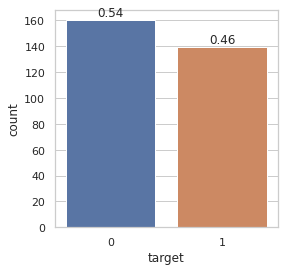

In [ ]:
fig_target, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

plotTarget()

AttributeError: ignored

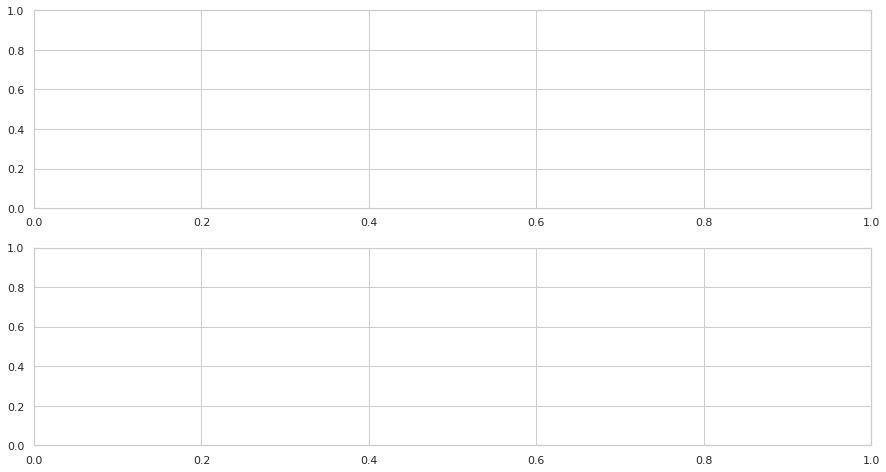

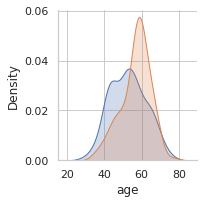

In [ ]:
fig_age, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))

plotAge()

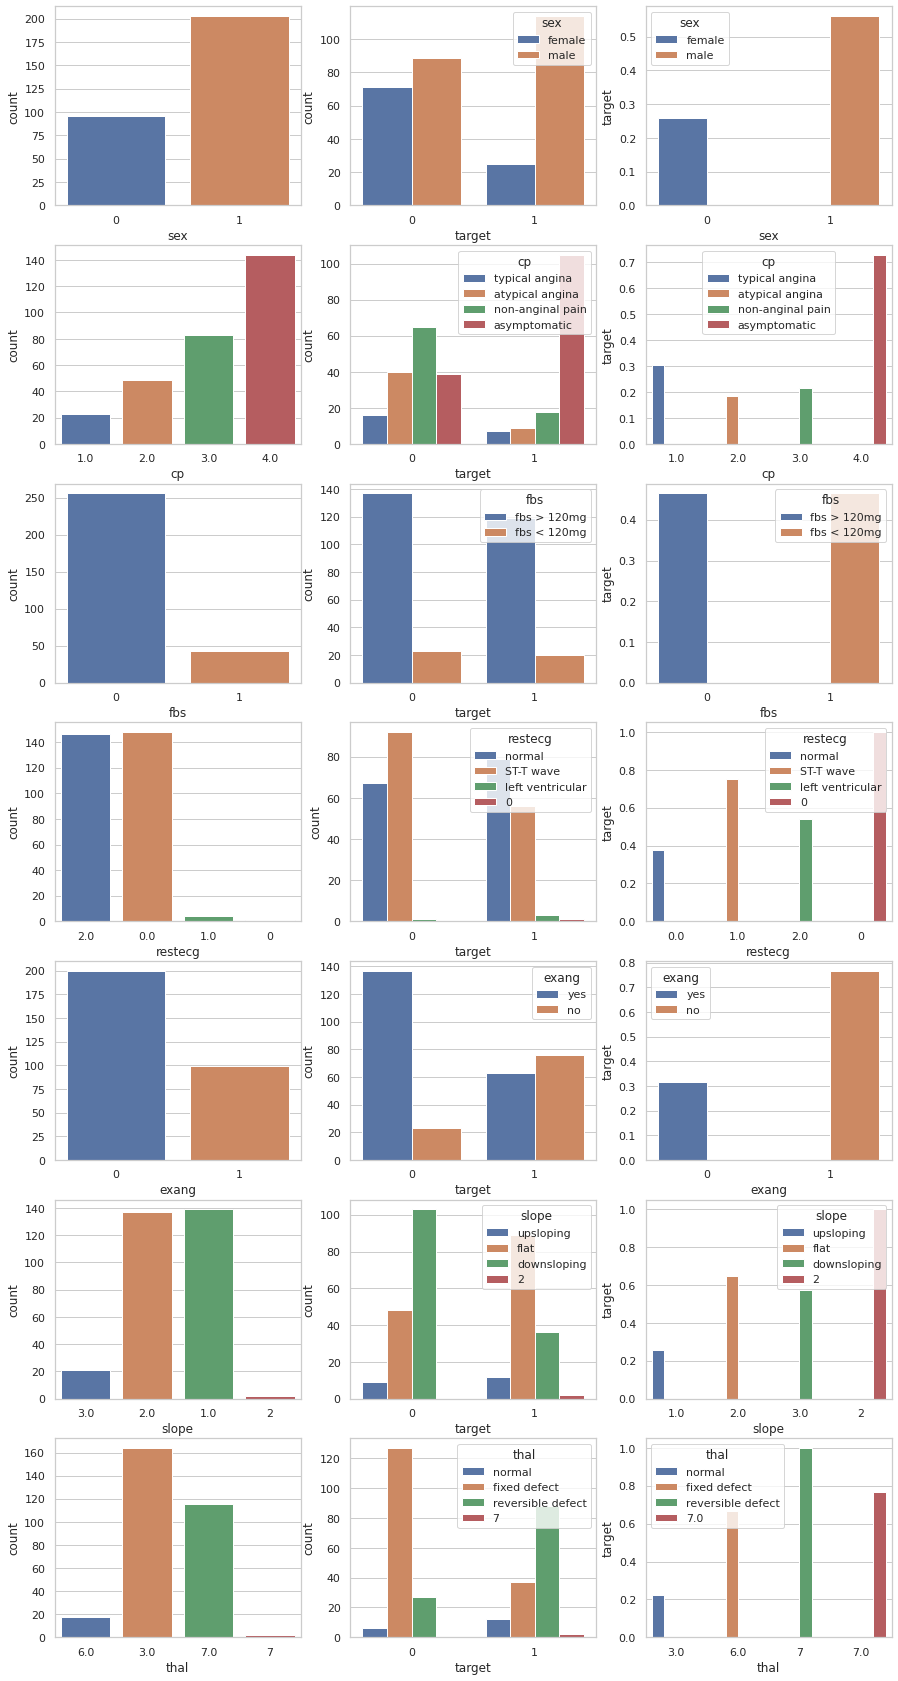

In [ ]:
fig_categorial, axes = plt.subplots(nrows=len(categorial), ncols=3, figsize=(15, 30))

plotGrid(isCategorial=True)

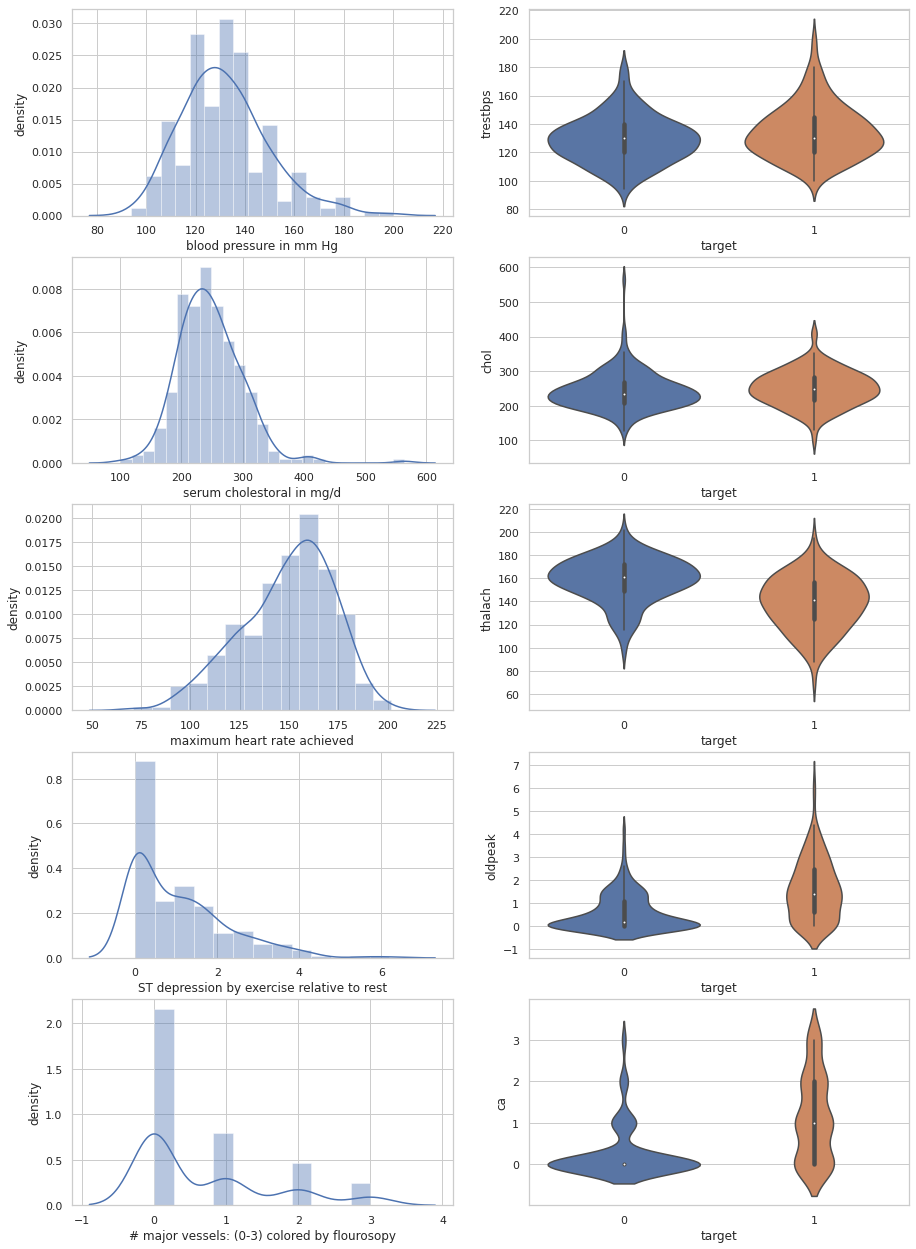

In [ ]:
fig_continuous, axes = plt.subplots(nrows=len(continuous), ncols=2, figsize=(15, 22))

plotGrid(isCategorial=False)

In [ ]:
cp_dummy = pd.get_dummies(df['cp'])
cp_dummy.rename(columns={1: 'cp_typical_angina', 2: 'cp_atypical_angina',
                         3: 'cp_non_angina', 4: 'cp_asymptomatic_angina'}, inplace=True)
restecg_dummy = pd.get_dummies(df['restecg'])
restecg_dummy.rename(columns={0: 'restecg_normal', 1: 'restecg_wave_abnorm',
                              2: 'restecg_ventricular_ht'}, inplace=True)
slope_dummy = pd.get_dummies(df['slope'])
slope_dummy.rename(columns={1: 'slope_upsloping', 2: 'slope_flat',
                            3: 'slope_downsloping'}, inplace=True)
thal_dummy = pd.get_dummies(df['thal'])
thal_dummy.rename(columns={3: 'thal_normal', 6: 'thal_fixed_defect',
                           7: 'thal_reversible_defect'}, inplace=True)
df = pd.concat([df, cp_dummy, restecg_dummy, slope_dummy, thal_dummy], axis=1)

df.drop(['cp', 'restecg', 'slope', 'thal'], axis=1, inplace=True)

In [ ]:
df_X = df.drop('target', axis=1)
df_y = df['target']

In [ ]:
selected_features = []
rfe = RFE(LogisticRegression())

rfe.fit(df_X.values, df_y.values)

for i, feature in enumerate(df_X.columns.values):
    if rfe.support_[i]:
        selected_features.append(feature)

selected_X = df_X[selected_features]
selected_y = df_y

lm = sm.Logit(selected_y, selected_X)
result = lm.fit()

print(result.summary2())

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Optimization terminated successfully.
         Current function value: 0.344950
         Iterations 7
                            Results: Logit
Model:                 Logit             Pseudo R-squared:  0.501     
Dependent Variable:    target            AIC:               230.2802  
Date:                  2022-04-10 08:39  BIC:               274.6855  
No. Observations:      299               Log-Likelihood:    -103.14   
Df Model:              11                LL-Null:           -206.51   
Df Residuals:          287               LLR p-value:       2.9570e-38
Converged:             1.0000            Scale:             1.0000    
No. Iterations:        7.0000                                         
----------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------------
sex                     0.7136   0.4156  1.7170 0.0860 -0.1010  1.5282
exa

In [ ]:
selected_X_train, selected_X_test, selected_y_train, selected_y_test = split(selected_X, selected_y, test_size=0.3, random_state=0)

In [ ]:
lr = LogisticRegression()
lr.fit(selected_X_train, selected_y_train)

print(f"Accuracy: {lr.score(selected_X_test, selected_y_test):0.3f}")

Accuracy: 0.856


In [ ]:
parameters = [{'kernel': ['rbf'], 'gamma': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5],
               'C': [1, 10, 100]},
              {'kernel': ['linear'], 
               'C': [1, 10, 100]}]
grid = GridSearchCV(svm.SVC(decision_function_shape='ovr'), parameters, cv=5)
grid.fit(selected_X_train, selected_y_train)
grid_means = grid.cv_results_['mean_test_score']
grid_stds = grid.cv_results_['std_test_score']

for mean, std, params in zip(grid_means, grid_stds, grid.cv_results_['params']):
    print(f"{mean:.3f} (+/-{std * 2:.03f}) for {params}")

0.545 (+/-0.009) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.579 (+/-0.051) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.837 (+/-0.046) for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.804 (+/-0.085) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.794 (+/-0.056) for {'C': 1, 'gamma': 0.2, 'kernel': 'rbf'}
0.785 (+/-0.027) for {'C': 1, 'gamma': 0.5, 'kernel': 'rbf'}
0.579 (+/-0.051) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.837 (+/-0.046) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.828 (+/-0.075) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.789 (+/-0.072) for {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.775 (+/-0.077) for {'C': 10, 'gamma': 0.2, 'kernel': 'rbf'}
0.780 (+/-0.073) for {'C': 10, 'gamma': 0.5, 'kernel': 'rbf'}
0.837 (+/-0.046) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.828 (+/-0.075) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.804 (+/-0.069) for {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
0.770 (+/-0.060) for {'C': 100, 'gamma': 0.1, 'kernel':

In [ ]:
svm_linear = svm.SVC(kernel='linear', C=10)
svm_linear.fit(selected_X_train, selected_y_train)

print(f"Accuracy: {svm_linear.score(selected_X_test, selected_y_test):.3f}")

Accuracy: 0.822


In [ ]:
kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=7)
models = [('Linear regression', lr), 
          ('Support vector machine', svm_linear)]

for model in models:
    results = model_selection.cross_val_score(model[1], 
                                              selected_X_train, 
                                              selected_y_train, 
                                              cv=kfold, 
                                              scoring='accuracy')
    print(f"Cross validated', {model[0]}, 'Accuracy: {results.mean():.3f}")

Cross validated', Linear regression, 'Accuracy: 0.828
Cross validated', Support vector machine, 'Accuracy: 0.852
